**Previsão de preços de casas com Python**

Nesta tarefa sobre Previsão de preços de casas usando aprendizado de máquina, nossa tarefa é usar dados do censo da Califórnia para criar um modelo de aprendizado de máquina para prever preços de casas no estado. Os dados incluem recursos como população, renda média e preços médios de casas para cada grupo de quarteirões na Califórnia.

Os grupos de quarteirões são a menor unidade geográfica que normalmente tem uma população de 600 a 3.000 pessoas. Podemos chamá-los de distritos para abreviar. Em última análise, nosso modelo de aprendizado de máquina deve aprender com esses dados e ser capaz de prever o preço médio da casa em qualquer bairro, considerando todas as outras métricas.

In [1]:
from google.colab import files
uploaded = files.upload()
#carregou o arquivo

Saving housing.csv to housing.csv


In [4]:
import pandas as pd
housing = pd.read_csv("housing.csv")
housing.head()
#leu o arquivo


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

Cada linha representa um distrito e há 10 atributos no conjunto de dados.

Agora vamos usar o método info() que é útil para obter uma descrição rápida dos dados, especialmente o número total de linhas, o tipo de cada atributo e o número de valores diferentes de zero:

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


**Há 20.640 instâncias no conjunto de dados. Observe que o atributo total_bedrooms possui apenas 20.433 valores diferentes de zero, o que significa que 207 distritos não contêm valores. Teremos que lidar com isso mais tarde.**

Todos os atributos são numéricos, exceto o campo ocean_proximity. Seu tipo é um objeto, portanto, pode conter qualquer tipo de objeto Python. Você pode descobrir quais categorias existem nessa coluna e quantos distritos pertencem a cada categoria usando o método value_counts():

In [6]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Outra maneira rápida de ter uma ideia do tipo de dados com os quais você está lidando é traçar um histograma para cada atributo numérico:

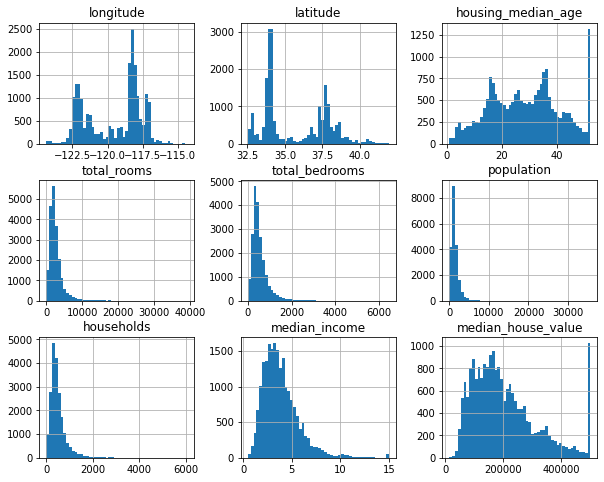

In [7]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(10, 8))
plt.show()

**A próxima etapa nesta tarefa de Previsão de Preços Internos é dividir os dados em conjuntos de treinamento e teste. Criar um conjunto de teste é teoricamente simples: selecione algumas instâncias aleatoriamente, normalmente 20% do conjunto de dados (ou menos, se o conjunto de dados for muito grande) e reserve-as:**

In [8]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

Vamos dar uma olhada mais de perto no histograma da renda mediana, já que a maioria dos valores de renda mediana se agrupa em torno de 1,5 a 6, mas algumas rendas medianas vão muito além de 6.

É importante ter um número suficiente de instâncias em seu conjunto de dados para cada estrato, caso contrário, a estimativa da importância de um estrato pode ser tendenciosa. Isso significa que você não deve ter muitos estratos e que cada estrato deve ser grande o suficiente: 

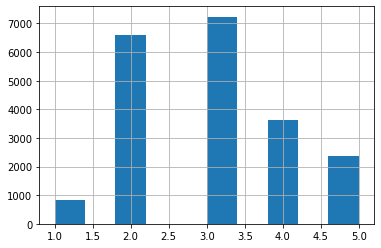

In [9]:
import numpy as np
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing['income_cat'].hist()
plt.show()

Amostragem estratificada no conjunto de dados
Agora, o próximo passo é realizar uma amostragem estratificada no conjunto de dados. Agora está pronto para realizar a amostragem estratificada com base na categoria de renda. Para isso foi usado a classe StratifiedShuffleSplit do Scikit-Learn:

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
print(strat_test_set['income_cat'].value_counts() / len(strat_test_set))

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64


Agora vamos remover o atributo Income_cat adicionado por nós para obter os dados de volta ao formulário:

In [11]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)
housing = strat_train_set.copy()

Agora, antes de criar um modelo de aprendizado de máquina para previsão de preços de casas com Python, vamos visualizar os dados em termos de longitude e latitude:

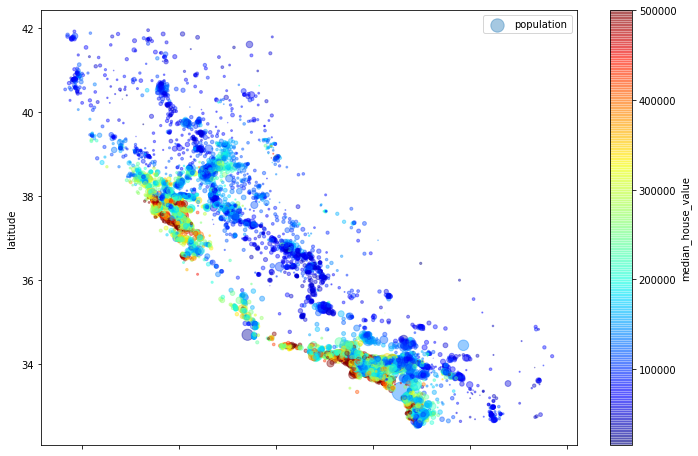

In [12]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population']/100, label='population',
figsize=(12, 8), c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()
plt.show()

**O gráfico mostra os preços das casas na Califórnia, onde o vermelho é caro, o azul é barato, os círculos maiores indicam áreas com uma população maior.**

Encontrando correlações
Como o conjunto de dados não é muito grande, podemos calcular facilmente o coeficiente de correlação padrão entre cada par de atributos usando o método corr():

In [13]:
corr_matrix = housing.corr()
print(corr_matrix.median_house_value.sort_values(ascending=False))

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


**Os intervalos de correlação estão entre -1 e 1. Quando está próximo de 1 significa que há uma correlação positiva e quando está perto de -1 significa que há uma correlação negativa. Quando está próximo de 0, significa que não há correlação linear.**

E agora vamos examinar a matriz de correlação novamente adicionando três novas colunas ao conjunto de dados; quartos por domicílio, quartos por cômodo e população por domicílio:

In [14]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

corr_matrix = housing.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64


Preparação de dados
Agora, este é o passo mais importante antes de treinar um modelo de aprendizado de máquina para a tarefa de previsão de preços de casas. Agora vamos realizar todas as transformações de dados necessárias:

In [15]:
# Data Preparation
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

housing_num = housing.drop("ocean_proximity", axis=1)

from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

Como você pode ver, há muitas etapas de transformação de dados que precisam ser executadas na ordem correta. Felizmente, o Scikit-Learn fornece a classe Pipeline para ajudá-lo com essas sequências de transformações. Aqui está um pequeno pipeline para atributos numéricos:

In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

**Regressão linear para previsão de preços de casas com Python
Agora vou usar o algoritmo de regressão linear para a tarefa de previsão de preços de casas com Python:**

In [17]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

data = housing.iloc[:5]
labels = housing_labels.iloc[:5]
data_preparation = full_pipeline.transform(data)
print("Predictions: ", lin_reg.predict(data_preparation))

Predictions:  [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
